In [51]:
# Import packages, testdata, the Y-matrix for the dataset and Functions.py
import numpy as np
%run 1.Dublin_data_import.ipynb
import sys
sys.path.append('../')
from Functions import *
import copy
import random
%store -r random_numbers_matrix

In [52]:
# Define the model parameter
num_samples = 410
alpha = 2
alpha_prior = 2
dim = 10

In [53]:
def LR(x):
    return np.exp(-x/200)*0.01+0.0001

In [54]:
# Define the metrics for all 4 models
True_posetiv = np.zeros(len(random_numbers_matrix))
True_negativ = np.zeros(len(random_numbers_matrix))
False_posetiv = np.zeros(len(random_numbers_matrix))
False_negativ = np.zeros(len(random_numbers_matrix))

True_posetiv_prior = np.zeros(len(random_numbers_matrix))
True_negativ_prior = np.zeros(len(random_numbers_matrix))
False_posetiv_prior = np.zeros(len(random_numbers_matrix))
False_negativ_prior = np.zeros(len(random_numbers_matrix))

True_posetiv_baseline = np.zeros(len(random_numbers_matrix))
True_negativ_baseline = np.zeros(len(random_numbers_matrix))
False_posetiv_baseline = np.zeros(len(random_numbers_matrix))
False_negativ_baseline = np.zeros(len(random_numbers_matrix))

True_posetiv_stupid_baseline = np.zeros(len(random_numbers_matrix))
True_negativ_stupid_baseline = np.zeros(len(random_numbers_matrix))
False_posetiv_stupid_baseline = np.zeros(len(random_numbers_matrix))
False_negativ_stupid_baseline = np.zeros(len(random_numbers_matrix))

Accuracy = np.zeros(len(random_numbers_matrix))
Accuracy_prior = np.zeros(len(random_numbers_matrix))
Accuracy_baseline = np.zeros(len(random_numbers_matrix))
Accuracy_stupid_baseline = np.zeros(len(random_numbers_matrix))

In [55]:
# The forloop run over one testset, and compute the latent space for the LDM with and without a prior
# Then the values are inserted in the metrics above
for s in range((1)):
    Y_updated = np.delete(Y,random_numbers_matrix[s].flatten().astype(int), axis=0)
    connections = Y[random_numbers_matrix[s].flatten().astype(int),0]
    points_copy = copy.deepcopy(points)
    points_copy_prior = copy.deepcopy(points)


    prev_grad = 200
    grad = 0
    k = 0
    while abs(prev_grad - grad) > 0.1: # stopping criteria
        print(prev_grad - grad)
        grad_sum = 0
        prev_grad = grad
        for i in range(1,num_samples+1):
            grad_now = Gradient_function_fast(i,dim,Y_updated,points_copy,alpha)
            grad_sum += np.sum((grad_now)**2)
            points_copy[i] += LR(k)*grad_now
        grad = grad_sum
        k += 1

    prev_grad = 200
    grad = 0
    k = 0
    while abs(prev_grad - grad) > 0.1: # stopping criteria
        print(prev_grad - grad)
        grad_sum = 0
        prev_grad = grad
        for i in range(1,num_samples+1):
            grad_now = Gradient_function_prior_fast(i,dim,Y_updated,points_copy_prior,alpha_prior)
            grad_sum += np.sum((grad_now)**2)
            points_copy_prior[i] += LR(k)*grad_now 
        grad = grad_sum
        k += 1


    point_a = [points_copy[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),1]]
    point_b = [points_copy[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),2]]
    points_a_np = np.array(point_a)
    points_b_np = np.array(point_b)
    distances = np.sum((points_a_np - points_b_np) ** 2, axis=1)
    sigmoid_value = 1 / (1 + np.exp(-1 * (alpha - distances)))

    point_a = [points_copy_prior[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),1]]
    point_b = [points_copy_prior[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),2]]
    points_a_np = np.array(point_a)
    points_b_np = np.array(point_b)
    distances_prior = np.sum((points_a_np - points_b_np) ** 2, axis=1)
    sigmoid_value_prior = 1 / (1 + np.exp(-1 * (alpha_prior - distances_prior)))

    True_posetiv[s] = np.sum(connections*sigmoid_value >= 0.5)
    False_posetiv[s] = np.sum(connections*sigmoid_value <= -0.5)
    True_negativ[s] = np.sum((connections*sigmoid_value > -0.5) & (connections*sigmoid_value < 0))
    False_negativ[s] = np.sum((connections*sigmoid_value >= 0) & (connections*sigmoid_value < 0.5))

    True_posetiv_prior[s] = np.sum(connections*sigmoid_value_prior >= 0.5)
    False_posetiv_prior[s] = np.sum(connections*sigmoid_value_prior <= -0.5)
    True_negativ_prior[s] = np.sum((connections*sigmoid_value_prior > -0.5) & (connections*sigmoid_value_prior < 0))
    False_negativ_prior[s] = np.sum((connections*sigmoid_value_prior >= 0) & (connections*sigmoid_value_prior < 0.5))

    Baseline = Baseline_function(Y, random_numbers_matrix[s].flatten().astype(int), Y_updated)
    Baseline += 1
    True_posetiv_baseline[s] = np.sum(connections * Baseline >= 1.5)
    False_posetiv_baseline[s] = np.sum(connections * Baseline <= -1.5)
    True_negativ_baseline[s] = np.sum((connections * Baseline > -1.5) & (connections * Baseline <= -1))
    False_negativ_baseline[s] = np.sum((connections * Baseline >= 1) & (connections * Baseline < 1.5))
    
    True_posetiv_stupid_baseline[s] = np.sum(connections*159/len(Y) >= 0.5)
    False_posetiv_stupid_baseline[s] = np.sum(connections*159/len(Y) <= -0.5)
    True_negativ_stupid_baseline[s] = np.sum((connections*159/len(Y) > -0.5) & (connections*159/len(Y) <= 0))
    False_negativ_stupid_baseline[s] = np.sum((connections*159/len(Y) > 0) & (connections*159/len(Y) < 0.5))

    Accuracy[s] = (True_posetiv[s]+True_negativ[s])/(len(sigmoid_value))
    Accuracy_prior[s] = (True_posetiv_prior[s]+True_negativ_prior[s])/(len(sigmoid_value))
    Accuracy_baseline[s] = (True_posetiv_baseline[s]+True_negativ_baseline[s])/(len(Baseline))
    Accuracy_stupid_baseline[s] = (True_posetiv_stupid_baseline[s]+True_negativ_stupid_baseline[s])/(len(Baseline))

    print(s)

200
-2125009.355060916
1729535.971833889
120760.98723376502
61437.409175606386
33738.23628400607
21385.025281862967
19120.19191731594
14805.28639923688
10033.33904896729
9638.189580427104
10454.739208779662
9948.156879935792
8766.53001764197
7251.954332077352
4347.846883695587
3507.041520821411
3683.7770878051015
3526.287177204831
2988.5440421319217
1740.3654008018857
843.544197866453
2255.822787870071
3152.622970254699
3001.513892147952
2540.7439463470146
2044.4388621673352
1647.2608724017336
1136.8065856771427
751.4226126686663
679.0721577233235
667.1104073998576
390.920284177133
131.4393486391491
249.34347120109305
911.9586347161166
1666.490181479472
1875.3000200945498
1536.4587150837397
1073.2271681571947
877.6146240675844
986.6402939627442
1169.2206923380763
1230.0150185045823
1150.4012966595183
982.65179564963
960.8727512241439
1300.585270887981
1439.6402236391968
1012.3207253185883
607.6444319602015
397.61004172781395
299.9355026202684
255.93440867801837
246.39816745785174
279.2

In [19]:
print('Accuracy', Accuracy)
print('Accuracy_prior', Accuracy_prior)
print('Accuracy_stupid_baseline', Accuracy_stupid_baseline)
print('Accuracy_stupid_baseline', Accuracy_stupid_baseline)

print('Recall', True_posetiv/(True_posetiv+False_posetiv))
print('Recall_prior', True_posetiv_prior/(True_posetiv_prior+False_posetiv_prior))
print('Recall baseline', True_posetiv_baseline/(True_posetiv_baseline+False_posetiv_baseline))
print('Recall simple baseline', True_posetiv_stupid_baseline/(1))

print('Precision', True_posetiv/(True_posetiv+False_negativ))
print('Precision_prior', True_posetiv_prior/(True_posetiv_prior+False_negativ_prior))
print('Precision baseline', True_posetiv_baseline/(True_posetiv_baseline+False_negativ_baseline))
print('Precision simple baseline', True_posetiv_stupid_baseline/(1))

Accuracy [0.97876908 0.97829198 0.97984256 0.97531011 0.97841126]
Accuracy_prior [0.97924618 0.97781489 0.97984256 0.97531011 0.97912691]
Accuracy_stupid_baseline [0.96875    0.96767653 0.96934637 0.96374046 0.96552958]
Accuracy_stupid_baseline [0.96875    0.96767653 0.96934637 0.96374046 0.96552958]
Recall [0.79166667 0.78709677 0.82835821 0.87022901 0.88028169]
Recall_prior [0.78947368 0.77070064 0.80985915 0.8540146  0.87012987]
Recall baseline [0.81746032 0.79850746 0.80314961 0.83802817 0.90151515]
Recall simple baseline [0. 0. 0. 0. 0.]
Precision [0.4351145  0.4501845  0.43190661 0.375      0.43252595]
Precision_prior [0.45801527 0.44649446 0.44747082 0.38486842 0.46366782]
Precision baseline [0.39312977 0.39483395 0.39688716 0.39144737 0.41176471]
Precision simple baseline [0. 0. 0. 0. 0.]


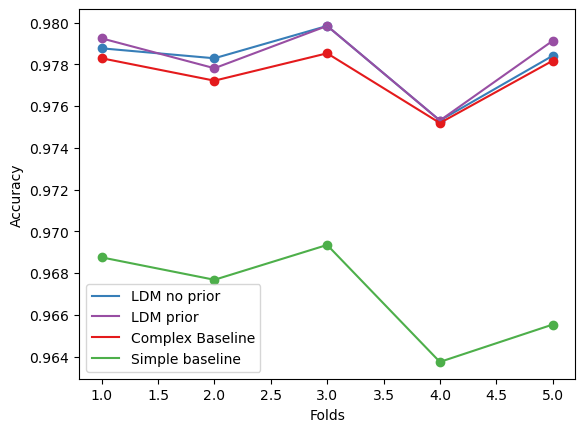

In [20]:
x = [1,2,3,4,5]
plt.plot(x,Accuracy,label='LDM no prior', color = '#377eb8')
plt.plot(x,Accuracy_prior, label='LDM prior', color = '#984ea3')
plt.plot(x,Accuracy_baseline, label='Complex Baseline', color = '#e41a1c')
plt.plot(x,Accuracy_stupid_baseline, label='Simple baseline', color = '#4daf4a')
plt.scatter(x, Accuracy, facecolors='#377eb8', edgecolors='#377eb8')
plt.scatter(x, Accuracy_prior, facecolors='#984ea3', edgecolors='#984ea3')
plt.scatter(x, Accuracy_baseline, facecolors='#e41a1c', edgecolors='#e41a1c')
plt.scatter(x, Accuracy_stupid_baseline, facecolors='#4daf4a', edgecolors='#4daf4a')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.legend()
plt.show()

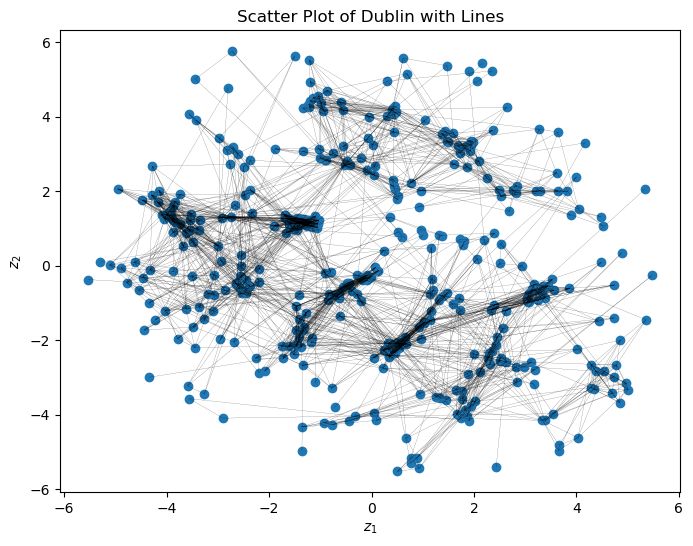

In [56]:
plt.figure(figsize=(8, 6))

for m in range(len(Y)): 
    if Y[m][0] == 1: # Check if there is a connection between Y[m][1] and Y[m][2]
        point1 = points_copy_prior[Y[m][1]]
        point2 = points_copy_prior[Y[m][2]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linewidth=0.1) # Ad a line between Y[m][1] and Y[m][2]

# extract the points and plot them
x = [point[0] for point in points_copy_prior.values()]
y = [point[1] for point in points_copy_prior.values()]
plt.scatter(x, y)

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Scatter Plot of Dublin with Lines')
plt.show()